In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pydriller
import pandas as pd
from tqdm import tqdm

repos = ['anyio', 'apscheduler', 'faststream']

rows = []

repo_myers = pydriller.Repository(repos, skip_whitespaces=True)
repo_hist = pydriller.Repository(repos, histogram_diff=True, skip_whitespaces=True)

for commit_myers, commit_hist in tqdm(
    zip(repo_myers.traverse_commits(), repo_hist.traverse_commits()),
    desc="Processing commits"
):
    for mf_myers, mf_hist in zip(commit_myers.modified_files, commit_hist.modified_files):
        if mf_hist.change_type.name != 'MODIFY' or mf_myers.change_type.name != 'MODIFY':
            continue

        added_myers = {line for _, line in mf_myers.diff_parsed['added']}
        deleted_myers = {line for _, line in mf_myers.diff_parsed['deleted']}
        added_hist = {line for _, line in mf_hist.diff_parsed['added']}
        deleted_hist = {line for _, line in mf_hist.diff_parsed['deleted']}

        discrepancy = not(added_myers == added_hist and deleted_hist == deleted_myers)

        rows.append([
            mf_myers.old_path,
            mf_myers.new_path,
            commit_myers.hash,
            commit_myers.parents[0] if commit_myers.parents else None,
            commit_myers.msg,
            mf_myers.diff,
            mf_hist.diff,
            discrepancy
        ])

df = pd.DataFrame(rows, columns=[
    'old_file path',
    'new_file path',
    'commit SHA',
    'parent commit SHA',
    'commit message',
    'diff_myers',
    'diff_hist',
    'discrepancy'
])

Processing commits: 3812it [07:07,  8.91it/s]


In [20]:
df.head(5)

,old_file path,new_file path,commit SHA,parent commit SHA,commit message,diff_myers,diff_hist,discrepancy
0,.travis.yml,.travis.yml,1cd65d62ec069a3c5a8f6af47b39127a85b4b69c,c0ceab67621285b6eea394f395c421dc3204d7b6,Fixed Travis and Tox configuration,"@@ -1,7 +1,7 @@\n language: python\n sudo: fal...","@@ -1,7 +1,7 @@\n language: python\n sudo: fal...",False
1,setup.cfg,setup.cfg,1cd65d62ec069a3c5a8f6af47b39127a85b4b69c,c0ceab67621285b6eea394f395c421dc3204d7b6,Fixed Travis and Tox configuration,"@@ -26,7 +26,7 @@ zip_safe = True\n install_re...","@@ -26,7 +26,7 @@ zip_safe = True\n install_re...",False
2,tox.ini,tox.ini,b35e3242c89bec6e9ef226ce737597f98f88e7d9,1cd65d62ec069a3c5a8f6af47b39127a85b4b69c,Added curio and trio to tox extras,"@@ -11,6 +11,8 @@ skip_missing_interpreters = ...","@@ -11,6 +11,8 @@ skip_missing_interpreters = ...",False
3,hyperio\__init__.py,hyperio\__init__.py,66272afcb5d350c94de2561b13353b7954eb42d2,b35e3242c89bec6e9ef226ce737597f98f88e7d9,Fixed typing imports on PyPy3 and Python 3.5.3,"@@ -1,12 +1,11 @@\n import sys\n import thread...","@@ -1,12 +1,11 @@\n import sys\n import thread...",False
4,hyperio\__init__.py,hyperio\__init__.py,542fd3738085876fc09be255dbb9d229aaa34408,66272afcb5d350c94de2561b13353b7954eb42d2,Fixed flake8 issues,"@@ -1,13 +1,13 @@\n import sys\n import thread...","@@ -1,13 +1,13 @@\n import sys\n import thread...",False


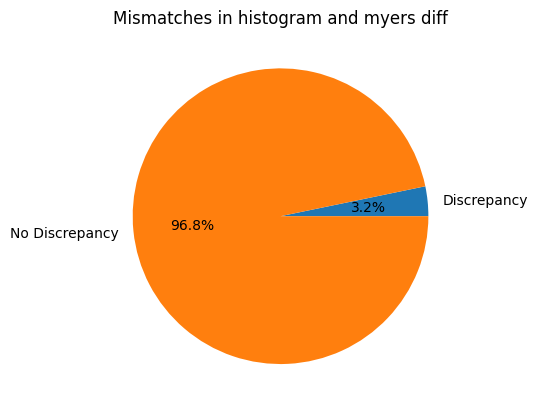

In [21]:
discrepancy_count = df['discrepancy'].sum()
no_discrepancy_count = len(df) - discrepancy_count

sizes = [discrepancy_count, no_discrepancy_count]
labels = ['Discrepancy', 'No Discrepancy']

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Mismatches in histogram and myers diff')
plt.show()

In [22]:
mismatch_data = df[df['discrepancy']]
test_mismatches = len(mismatch_data[mismatch_data['new_file path'].str.contains('test', case=False)])
readme_mismatches = len(mismatch_data[mismatch_data['new_file path'].str.contains('README', case=False)])
license_mismatches = len(mismatch_data[mismatch_data['new_file path'].str.contains('LICENSE', case=False)])

In [23]:
source_code_mismatches = len(mismatch_data) - test_mismatches - readme_mismatches - license_mismatches

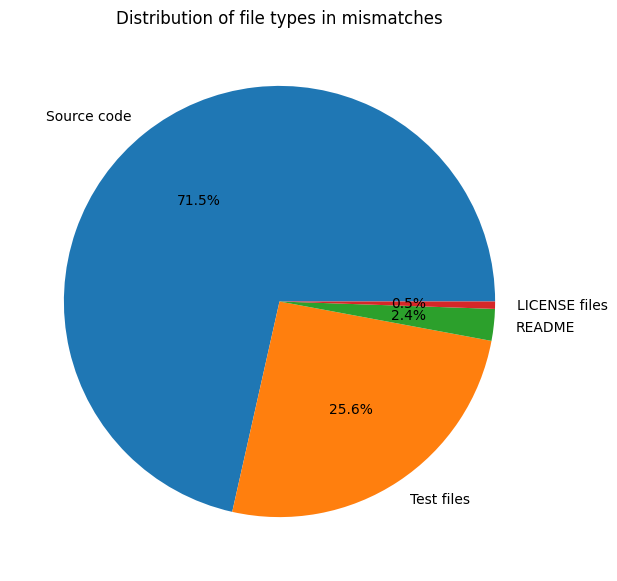

In [24]:
sizes = [source_code_mismatches, test_mismatches, readme_mismatches, license_mismatches]
labels = ['Source code', 'Test files', 'README', 'LICENSE files']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of file types in mismatches')
plt.show()

In [25]:
df.to_csv('consolidated_diff_data.csv', escapechar='\\')

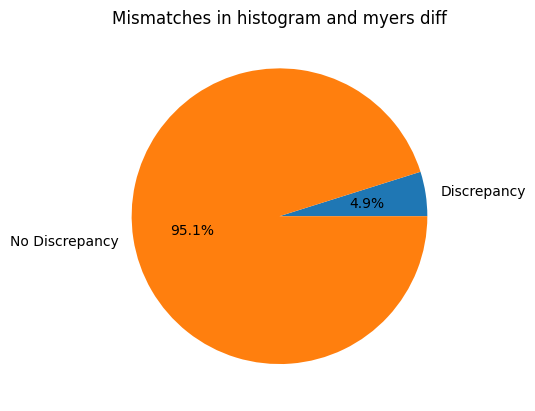

In [26]:
#lets see the distribution if we just compared the two diffs considering them as strings.

discrepancy_count = sum(df['diff_hist'] != df['diff_myers'])
no_discrepancy_count = len(df) - discrepancy_count

sizes = [discrepancy_count, no_discrepancy_count]
labels = ['Discrepancy', 'No Discrepancy']

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Mismatches in histogram and myers diff')
plt.show()

In [27]:
df = pd.read_csv('consolidated_diff_data.csv', escapechar='\\')

def find_relative_mismatches(typ):
    num = df[df['discrepancy'] & df['new_file path'].str.contains(typ, case=False, na=False)]
    den = df[df['new_file path'].str.contains(typ, case=False, na=False)]

    print(f"Relative mismatches for {typ}:", len(num) / len(den))
    return len(num), len(den)

tn, td = find_relative_mismatches('test')
ln, ld = find_relative_mismatches('LICENSE')
rn, rd = find_relative_mismatches('README')

tot = len(df[df['discrepancy']])

print("Relative number of relative mismatches for source code files:", (tot - tn - ln - rn)/ (len(df) - td - ld - rd))

Relative mismatches for test: 0.033597312215022795
Relative mismatches for LICENSE: 0.16666666666666666
Relative mismatches for README: 0.07514450867052024
Relative number of relative mismatches for source code files: 0.03128750900216052


In [28]:
print("Number of mismatches in source code files", tot - tn - ln - rn)
print("Number of mismatches in test code files", tn)
print("Number of mismatches in LICENSE files", ln)
print("Number of mismatches in README files", rn)

Number of mismatches in source code files 391
Number of mismatches in test code files 140
Number of mismatches in LICENSE files 3
Number of mismatches in README files 13
